# Full Controllability: Falcon-7b

Here we will analyze the results in `ctrl1_falcon7b_*_of_32.csv`. 
 - [ ] Load in all the CSVs, concatenate into 1 big results CSV. 
 - [ ] Plot the portion of uncontrollable instances as a function of $k$. 
 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from ast import literal_eval

# seaborn 
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

## Plotting Functions

In [10]:
def add_zero_prompt_length(df_in): 
    # set prompt_length to zero when base_correct is true 
    df_in.loc[df_in['base_correct'] == True, 'prompt_length'] = 0
    return df_in

In [11]:
def overview_report(df_in): 
    print("Mean prompt correct (epsilon): \t", df_in['prompt_correct'].mean())
    print("Mean prompt correct with k <= 4: ", len(df_in[df_in['prompt_length'] <= 4]) / len(df_in))
    print("Mean base correct: \t\t", df_in['base_correct'].mean())
    print("Mean prompt length: \t\t", df_in['prompt_length'].mean())


In [12]:
def k_epsilon_line_plot(df_in,
                        title="TITLE",
                        output_path=None, 
                        figsize=(6, 4), 
                        log_y=False): 
    # Placeholder for the final percentages
    results = []

    # For each unique question_length
    question_lengths = df_in['question_length'].unique().tolist()
    question_lengths.sort()
    for q_len in question_lengths:
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]

        percentage_correct = []
        prompt_lengths = sorted(temp_df['prompt_length'].unique())
        prompt_lengths = [0] + prompt_lengths
        for p_len in prompt_lengths:
            # Calculate the percentage for this prompt_length
            portion = temp_df[temp_df['prompt_length'] <= p_len]
            correct = portion['prompt_correct'].sum()
            total = len(temp_df)
            percentage = 1-(correct/total)
            percentage_correct.append((p_len, percentage))

        results.append((q_len, percentage_correct))

    # Plotting
    plt.figure(figsize=figsize)

    for q_len, percentages in results:
        x, y = zip(*percentages)
        y = np.array(y)
        plt.plot(x, y, label=f'Question Length {q_len}')

    plt.xlabel('Prompt Length [k]')

    
    
    # logarithmic y-axis 
    if log_y: 
        plt.yscale('log')
        plt.ylabel('Log(Portion Incorrect) [log(epsilon)]')
    else:
        plt.ylabel('Portion Incorrect [epsilon]')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    # plt.yscale('log')
    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    return results


In [13]:
def loss_k_correlation_plots(df_in, 
                             suptitle="TITLE", 
                             output_path=None, 
                             figsize=(8, 9)):
    solved_df = df_in[df_in['prompt_correct'] == 1]
    question_lengths = solved_df['question_length'].unique().tolist()
    question_lengths.sort()

    # make a 3 by 2 grid of plots
    fig, axs = plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)
    # sharex and sharey
    print(question_lengths)
    # plot a scatter plot of base_correct vs. prompt_length
    for idx_, q_len in enumerate(question_lengths):
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]
        idx = idx_ + 1
        axs[idx//2, idx%2].scatter(temp_df['base_loss'], temp_df['prompt_length'], alpha=0.5)
        axs[idx//2, idx%2].set_xlabel('Base Loss')
        axs[idx//2, idx%2].set_ylabel('Prompt Length [k]')

        # compute the Pearson correlation coefficient between base_loss and prompt_length
        corr = temp_df['base_loss'].corr(temp_df['prompt_length'])
        print(f'Pearson correlation coefficient (q_len={q_len}): {corr}')
        axs[idx//2, idx%2].set_title(f'Question Len {q_len}: Corr={corr:.2f}')

    # Now we add the overall plot in axs[0,0] 
    axs[0,0].scatter(solved_df['base_loss'], solved_df['prompt_length'], alpha=0.5, c='r')    
    axs[0,0].set_xlabel('Base Loss')
    axs[0,0].set_ylabel('Prompt Length [k]')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])
    axs[0,0].set_title(f'All Question Lengths -- Corr={corr:.2f}')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])

    # tight layout
    plt.suptitle(suptitle)
    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    


In [14]:
def get_prompt_token_freqs(df_in, 
                           tokenizer, 
                           num_to_prompt=20, 
                           title="TITLE", 
                           figsize=(12, 3), 
                           output_path=None): 
    prompt_tokens = df_in[df_in['base_correct'] == False]['best_prompt_ids'].tolist()
    prompt_tokens = [literal_eval(x) for x in prompt_tokens]
    all_prompt_tokens = []
    for x in prompt_tokens: 
        all_prompt_tokens += x
    
    # all_prompt_tokens is a list of all the prompt tokens (including duplicates). 
    # We want to count the number of times each token appears in the list.
    # We can use a dictionary to do this.
    prompt_token_freqs = {}
    for token in all_prompt_tokens:
        if token in prompt_token_freqs:
            prompt_token_freqs[token] += 1
        else:
            prompt_token_freqs[token] = 1

    # now let's sort the dictionary by value
    prompt_token_freqs = {k: v for k, v in sorted(prompt_token_freqs.items(), key=lambda item: item[1], reverse=True)}


    # Let's plot the top 20 tokens
    top_20_tokens = list(prompt_token_freqs.keys())[:num_to_prompt]
    top_20_freqs = list(prompt_token_freqs.values())[:num_to_prompt]

    plt.figure(figsize=figsize)
    plt.bar([i for i in range(num_to_prompt)], top_20_freqs)
    plt.xticks([i for i in range(num_to_prompt)], [tokenizer.decode([x]) for x in top_20_tokens], rotation=90)
    plt.xlabel('Token')
    plt.ylabel('Frequency')
    plt.title(title)

    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)

    return prompt_token_freqs


## Falcon-7b Controllability

In [15]:
# Load in the CSV -- use glob to get all CSVs of the name `ctrl1_falcon7b_*_of_32.csv`
path = r'ctrl1_falcon7b_*_of_32.csv'
all_files = glob.glob(path)
li = []

# Iterate through all files and append to a list
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# Concatenate all files into one DataFrame
df_falcon_7b = pd.concat(li, axis=0, ignore_index=True)
df_falcon_7b.head()

,question,question_ids,answer,answer_ids,base_loss,search_method,best_prompt,best_prompt_ids,prompt_length,prompted_loss,base_correct,prompt_correct,question_length
0,"the outgoing President, saying, "" For myself ...","[248, 33750, 3503, 204, 23, 3225, 204, 23, 204...",techn,18355,21.125,gcg,scientific,"[6963, 18355, 381, 25161, 29904, 37984, 24804,...",8,1.867188,False,True,32
1,"Friends. Six members of the public, named Bar...","[13725, 204, 25, 12732, 2094, 275, 248, 1202, ...",absor,60729,19.625,gcg,lockdown,"[15332, 49857, 1977, 28818, 46937, 23562, 75, ...",10,9.125000,False,False,32
2,"( 54 @,@ 000 sq ft ) was closed for investiga...","[204, 19, 204, 6698, 204, 43, 23, 43, 204, 132...",volunteers,11537,15.625,gcg,unstable,"[29372, 46031, 1233, 45702, 61792, 41541, 1105...",10,0.333984,False,True,32
3,"around the New Zealand battalion, which was s...","[1111, 248, 1184, 10891, 59603, 204, 23, 585, ...",patriotic,49411,18.125,gcg,Feedback,"[47368, 49411, 39447, 8888, 23220, 51461]",6,0.236328,False,True,32
4,factors were attributed with Oxford's substan...,"[4561, 646, 20750, 335, 14068, 204, 18, 94, 10...",ministre,54971,19.500,gcg,\n,"[33791, 27860, 53782, 60300, 996, 28128, 44863...",10,12.187500,False,False,32


Outputting the CSV to `ctrl1_k10_falcon_7b_1250.csv`.

In [16]:
output_csv_path = 'ctrl1_k10_falcon7b_1250.csv'
if os.path.exists(output_csv_path):
    print(f'WARNING: {output_csv_path} already exists. Skipping.')
else: 
    df_falcon_7b.to_csv(output_csv_path, index=False, lineterminator='\n')

In [8]:
overview_report(df_falcon_7b)

Mean prompt correct (epsilon): 	 0.5127388535031847
Mean prompt correct with k <= 4:  0.14251592356687898
Mean base correct: 		 0.0
Mean prompt length: 		 8.297770700636942


In [9]:
# What fraction had base_correct true? 
df['base_correct'].value_counts(normalize=True)

base_correct
False    1.0
Name: proportion, dtype: float64

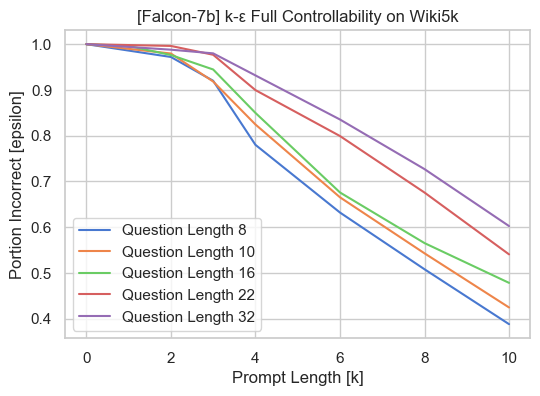

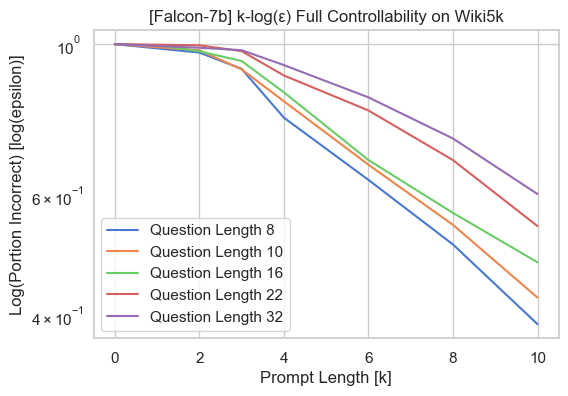

In [10]:
results = k_epsilon_line_plot(df_falcon_7b,
                    title="[Falcon-7b] k-ε Full Controllability on Wiki5k",
                    output_path='line_plot.pdf')


results_log = k_epsilon_line_plot(df_falcon_7b,
                    title="[Falcon-7b] k-log(ε) Full Controllability on Wiki5k",
                    output_path='log_line_plot.pdf',
                    log_y=True)


[8, 10, 16, 22, 32]
Pearson correlation coefficient (q_len=8): 0.425804759251856
Pearson correlation coefficient (q_len=10): 0.3847042892600029
Pearson correlation coefficient (q_len=16): 0.48132028058936244
Pearson correlation coefficient (q_len=22): 0.34319510762335537
Pearson correlation coefficient (q_len=32): 0.36676004380390353


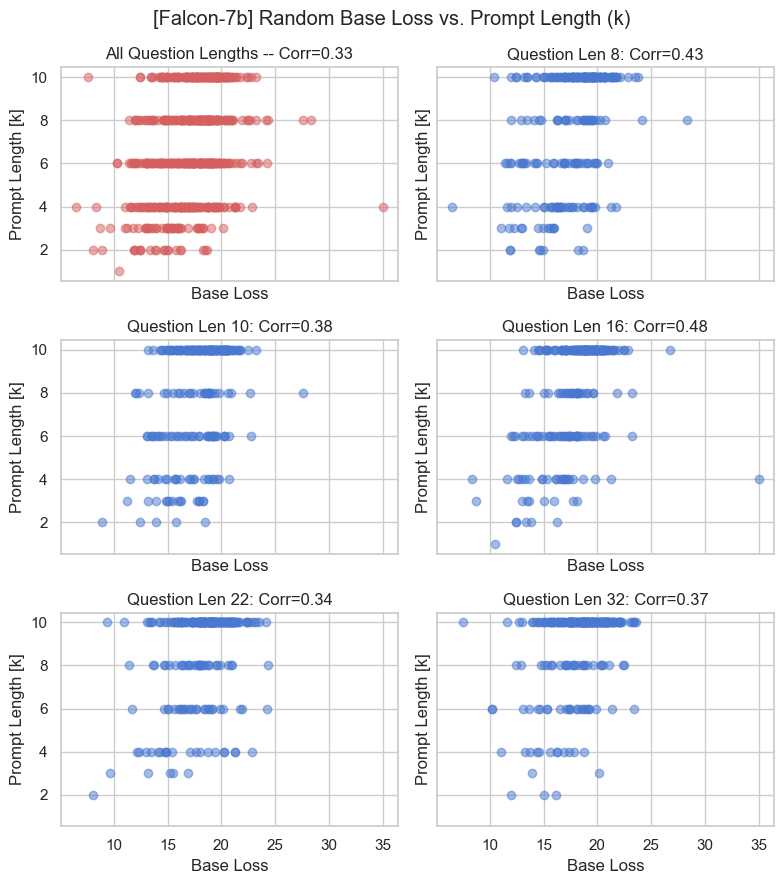

In [11]:
loss_k_correlation_plots(df_falcon_7b, 
                         suptitle="[Falcon-7b] Random Base Loss vs. Prompt Length (k)", 
                         output_path='base_loss_vs_prompt_length.pdf')


## Rank vs. Prompt Length

Let's plot the rank of the next token logit versus the required prompt length k. 

This will inform our experiments where we restrict the desired next token to a 
set defined via the logits (e.g., top $z$ logits). 

In [12]:
# Load the falcon-7b model and tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy 

tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b")
model = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-7b")

/Users/aman/Documents/Magic_Words/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
(…)iiuae/falcon-7b/resolve/main/config.json: 100%|██████████| 1.05k/1.05k [00:00<00:00, 1.45MB/s]
(…)esolve/main/pytorch_model.bin.index.json: 100%|██████████| 16.9k/16.9k [00:00<00:00, 46.2MB/s]

In [ ]:
model.half()
model.to('mps')